In [1]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1921k      0  0:00:06  0:00:06 --:--:-- 3127k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [2]:
data_dir = "data/animais"

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def show_images(images, titles=None, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
example_dir = os.path.join(data_dir, 'train')
example_set = datasets.ImageFolder(example_dir, transform=None)
example_images = [example_set[i][0] for i in random.sample(range(len(example_set)), 5)]

# Mostrando imagens originais
print("Imagens Originais")
show_images(example_images)

# Exemplo de RandomResizedCrop
cropped_images = [transforms.RandomResizedCrop(224)(img) for img in example_images]
print("Após RandomResizedCrop")
show_images(cropped_images)

# Exemplo de RandomHorizontalFlip
flipped_images = [transforms.RandomHorizontalFlip()(img) for img in cropped_images]
print("Após RandomHorizontalFlip")
show_images(flipped_images)

# Exemplo de RandomRotation
rotated_images = [transforms.RandomRotation(15)(img) for img in example_images]
print("Após RandomRotation")
show_images(rotated_images)

# Exemplo de RandomAffine
affined_images = [transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))(img) for img in example_images]
print("Após RandomAffine")
show_images(affined_images)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transform_aug = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 32 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes=2).to(device)

x = torch.randn(1, 3, 224, 224).to(device)
print(model(x).shape)

torch.Size([1, 2])


100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 1, Train Loss: 0.706, Train Accuracy: 50.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.710, Val Accuracy: 43.44%


100%|██████████| 13/13 [00:02<00:00,  5.25it/s]


Epoch 2, Train Loss: 0.694, Train Accuracy: 50.00%
Epoch 2, Val Loss: 0.697, Val Accuracy: 42.62%


100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


Epoch 3, Train Loss: 0.690, Train Accuracy: 56.75%
Epoch 3, Val Loss: 0.689, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


Epoch 4, Train Loss: 0.691, Train Accuracy: 53.75%
Epoch 4, Val Loss: 0.686, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch 5, Train Loss: 0.689, Train Accuracy: 53.00%
Epoch 5, Val Loss: 0.687, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


Epoch 6, Train Loss: 0.689, Train Accuracy: 54.25%
Epoch 6, Val Loss: 0.685, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  5.29it/s]


Epoch 7, Train Loss: 0.688, Train Accuracy: 57.00%
Epoch 7, Val Loss: 0.685, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 8, Train Loss: 0.685, Train Accuracy: 56.75%
Epoch 8, Val Loss: 0.680, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


Epoch 9, Train Loss: 0.683, Train Accuracy: 58.25%
Epoch 9, Val Loss: 0.677, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 10, Train Loss: 0.679, Train Accuracy: 64.00%
Epoch 10, Val Loss: 0.676, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:02<00:00,  4.82it/s]


Epoch 11, Train Loss: 0.667, Train Accuracy: 63.75%
Epoch 11, Val Loss: 0.662, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Epoch 12, Train Loss: 0.653, Train Accuracy: 61.75%
Epoch 12, Val Loss: 0.679, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:02<00:00,  5.30it/s]


Epoch 13, Train Loss: 0.641, Train Accuracy: 65.25%
Epoch 13, Val Loss: 0.646, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:02<00:00,  5.25it/s]


Epoch 14, Train Loss: 0.594, Train Accuracy: 67.00%
Epoch 14, Val Loss: 0.644, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 15, Train Loss: 0.561, Train Accuracy: 73.50%
Epoch 15, Val Loss: 0.754, Val Accuracy: 45.08%


100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


Epoch 16, Train Loss: 0.695, Train Accuracy: 54.25%
Epoch 16, Val Loss: 0.648, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:02<00:00,  5.19it/s]


Epoch 17, Train Loss: 0.575, Train Accuracy: 70.75%
Epoch 17, Val Loss: 0.593, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


Epoch 18, Train Loss: 0.513, Train Accuracy: 76.75%
Epoch 18, Val Loss: 0.631, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:02<00:00,  5.04it/s]


Epoch 19, Train Loss: 0.459, Train Accuracy: 81.25%
Epoch 19, Val Loss: 0.629, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


Epoch 20, Train Loss: 0.397, Train Accuracy: 82.00%
Epoch 20, Val Loss: 0.650, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


Epoch 21, Train Loss: 0.350, Train Accuracy: 86.50%
Epoch 21, Val Loss: 0.781, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


Epoch 22, Train Loss: 0.292, Train Accuracy: 89.25%
Epoch 22, Val Loss: 0.764, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


Epoch 23, Train Loss: 0.295, Train Accuracy: 86.50%
Epoch 23, Val Loss: 0.814, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch 24, Train Loss: 0.240, Train Accuracy: 90.75%
Epoch 24, Val Loss: 1.095, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


Epoch 25, Train Loss: 0.213, Train Accuracy: 91.75%
Epoch 25, Val Loss: 0.913, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch 26, Train Loss: 0.152, Train Accuracy: 94.75%
Epoch 26, Val Loss: 0.925, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch 27, Train Loss: 0.161, Train Accuracy: 92.50%
Epoch 27, Val Loss: 1.198, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


Epoch 28, Train Loss: 0.215, Train Accuracy: 91.25%
Epoch 28, Val Loss: 1.055, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.29it/s]


Epoch 29, Train Loss: 0.168, Train Accuracy: 93.75%
Epoch 29, Val Loss: 1.585, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:02<00:00,  5.33it/s]


Epoch 30, Train Loss: 0.140, Train Accuracy: 94.00%
Epoch 30, Val Loss: 1.586, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 31, Train Loss: 0.055, Train Accuracy: 98.75%
Epoch 31, Val Loss: 2.161, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


Epoch 32, Train Loss: 0.051, Train Accuracy: 98.00%
Epoch 32, Val Loss: 1.941, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


Epoch 33, Train Loss: 0.043, Train Accuracy: 98.50%
Epoch 33, Val Loss: 2.266, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 34, Train Loss: 0.050, Train Accuracy: 97.50%
Epoch 34, Val Loss: 1.961, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  4.42it/s]


Epoch 35, Train Loss: 0.225, Train Accuracy: 92.00%
Epoch 35, Val Loss: 1.302, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Epoch 36, Train Loss: 0.325, Train Accuracy: 88.50%
Epoch 36, Val Loss: 0.798, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


Epoch 37, Train Loss: 0.192, Train Accuracy: 93.00%
Epoch 37, Val Loss: 0.865, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch 38, Train Loss: 0.081, Train Accuracy: 97.25%
Epoch 38, Val Loss: 1.160, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch 39, Train Loss: 0.020, Train Accuracy: 100.00%
Epoch 39, Val Loss: 1.687, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


Epoch 40, Train Loss: 0.006, Train Accuracy: 100.00%
Epoch 40, Val Loss: 1.886, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch 41, Train Loss: 0.002, Train Accuracy: 100.00%
Epoch 41, Val Loss: 2.239, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


Epoch 42, Train Loss: 0.002, Train Accuracy: 100.00%
Epoch 42, Val Loss: 2.386, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  5.22it/s]


Epoch 43, Train Loss: 0.001, Train Accuracy: 100.00%
Epoch 43, Val Loss: 2.380, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 44, Train Loss: 0.001, Train Accuracy: 100.00%
Epoch 44, Val Loss: 2.457, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.33it/s]


Epoch 45, Train Loss: 0.001, Train Accuracy: 100.00%
Epoch 45, Val Loss: 2.553, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.25it/s]


Epoch 46, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 46, Val Loss: 2.565, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch 47, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 47, Val Loss: 2.503, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  4.87it/s]


Epoch 48, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 48, Val Loss: 2.515, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


Epoch 49, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 49, Val Loss: 2.581, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


Epoch 50, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 50, Val Loss: 2.627, Val Accuracy: 72.95%
Treinamento concluído


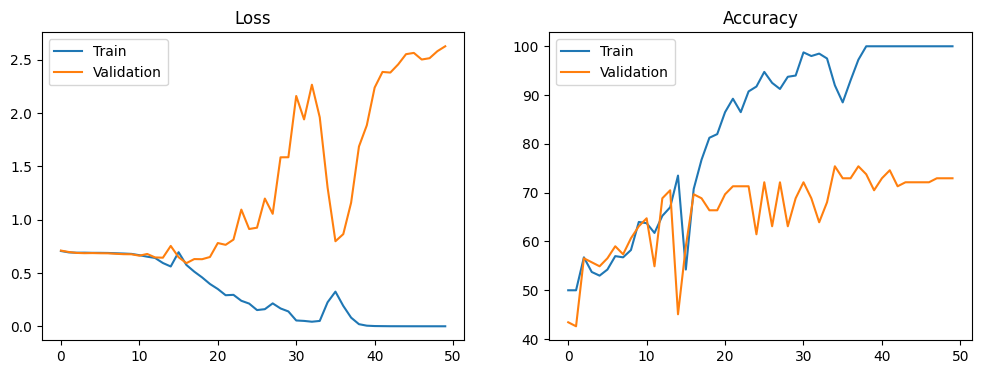

In [9]:
model_no_aug = CNN(num_classes=2).to(device)

criterion_no_aug = nn.CrossEntropyLoss()
optimizer_no_aug = optim.SGD(model_no_aug.parameters(), lr=0.01, momentum=0.9)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=50)

plot_history(history_no_aug)

100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


Epoch 1, Train Loss: 0.707, Train Accuracy: 50.00%
Epoch 1, Val Loss: 0.685, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Epoch 2, Train Loss: 0.695, Train Accuracy: 50.25%
Epoch 2, Val Loss: 0.694, Val Accuracy: 45.90%


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 3, Train Loss: 0.697, Train Accuracy: 48.00%
Epoch 3, Val Loss: 0.703, Val Accuracy: 43.44%


100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


Epoch 4, Train Loss: 0.696, Train Accuracy: 49.50%
Epoch 4, Val Loss: 0.694, Val Accuracy: 43.44%


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 5, Train Loss: 0.693, Train Accuracy: 51.50%
Epoch 5, Val Loss: 0.693, Val Accuracy: 50.00%


100%|██████████| 13/13 [00:02<00:00,  5.44it/s]


Epoch 6, Train Loss: 0.693, Train Accuracy: 50.25%
Epoch 6, Val Loss: 0.691, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


Epoch 7, Train Loss: 0.693, Train Accuracy: 50.25%
Epoch 7, Val Loss: 0.691, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


Epoch 8, Train Loss: 0.693, Train Accuracy: 51.75%
Epoch 8, Val Loss: 0.691, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 9, Train Loss: 0.693, Train Accuracy: 51.25%
Epoch 9, Val Loss: 0.689, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


Epoch 10, Train Loss: 0.692, Train Accuracy: 52.00%
Epoch 10, Val Loss: 0.691, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  4.52it/s]


Epoch 11, Train Loss: 0.693, Train Accuracy: 52.00%
Epoch 11, Val Loss: 0.690, Val Accuracy: 53.28%


100%|██████████| 13/13 [00:02<00:00,  5.54it/s]


Epoch 12, Train Loss: 0.691, Train Accuracy: 57.00%
Epoch 12, Val Loss: 0.689, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 13, Train Loss: 0.691, Train Accuracy: 55.50%
Epoch 13, Val Loss: 0.689, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 14, Train Loss: 0.689, Train Accuracy: 54.25%
Epoch 14, Val Loss: 0.686, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:03<00:00,  4.30it/s]


Epoch 15, Train Loss: 0.688, Train Accuracy: 57.00%
Epoch 15, Val Loss: 0.686, Val Accuracy: 53.28%


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 16, Train Loss: 0.690, Train Accuracy: 55.25%
Epoch 16, Val Loss: 0.683, Val Accuracy: 53.28%


100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Epoch 17, Train Loss: 0.688, Train Accuracy: 57.25%
Epoch 17, Val Loss: 0.682, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Epoch 18, Train Loss: 0.686, Train Accuracy: 54.75%
Epoch 18, Val Loss: 0.679, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


Epoch 19, Train Loss: 0.684, Train Accuracy: 55.00%
Epoch 19, Val Loss: 0.678, Val Accuracy: 54.10%


100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 20, Train Loss: 0.684, Train Accuracy: 56.00%
Epoch 20, Val Loss: 0.674, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


Epoch 21, Train Loss: 0.685, Train Accuracy: 56.25%
Epoch 21, Val Loss: 0.671, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


Epoch 22, Train Loss: 0.675, Train Accuracy: 57.00%
Epoch 22, Val Loss: 0.678, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:02<00:00,  5.57it/s]


Epoch 23, Train Loss: 0.682, Train Accuracy: 55.75%
Epoch 23, Val Loss: 0.652, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Epoch 24, Train Loss: 0.677, Train Accuracy: 53.75%
Epoch 24, Val Loss: 0.658, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:02<00:00,  5.30it/s]


Epoch 25, Train Loss: 0.673, Train Accuracy: 59.25%
Epoch 25, Val Loss: 0.668, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


Epoch 26, Train Loss: 0.667, Train Accuracy: 57.75%
Epoch 26, Val Loss: 0.656, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


Epoch 27, Train Loss: 0.687, Train Accuracy: 55.75%
Epoch 27, Val Loss: 0.689, Val Accuracy: 48.36%


100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


Epoch 28, Train Loss: 0.664, Train Accuracy: 62.50%
Epoch 28, Val Loss: 0.638, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


Epoch 29, Train Loss: 0.658, Train Accuracy: 61.75%
Epoch 29, Val Loss: 0.640, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Epoch 30, Train Loss: 0.660, Train Accuracy: 59.50%
Epoch 30, Val Loss: 0.630, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


Epoch 31, Train Loss: 0.667, Train Accuracy: 61.25%
Epoch 31, Val Loss: 0.639, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Epoch 32, Train Loss: 0.673, Train Accuracy: 61.25%
Epoch 32, Val Loss: 0.667, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:02<00:00,  4.44it/s]


Epoch 33, Train Loss: 0.670, Train Accuracy: 56.25%
Epoch 33, Val Loss: 0.650, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:02<00:00,  5.57it/s]


Epoch 34, Train Loss: 0.650, Train Accuracy: 62.00%
Epoch 34, Val Loss: 0.631, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Epoch 35, Train Loss: 0.628, Train Accuracy: 62.75%
Epoch 35, Val Loss: 0.610, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


Epoch 36, Train Loss: 0.627, Train Accuracy: 67.25%
Epoch 36, Val Loss: 0.577, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


Epoch 37, Train Loss: 0.647, Train Accuracy: 63.00%
Epoch 37, Val Loss: 0.585, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 38, Train Loss: 0.620, Train Accuracy: 65.50%
Epoch 38, Val Loss: 0.610, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Epoch 39, Train Loss: 0.611, Train Accuracy: 66.00%
Epoch 39, Val Loss: 0.588, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch 40, Train Loss: 0.610, Train Accuracy: 69.00%
Epoch 40, Val Loss: 0.562, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


Epoch 41, Train Loss: 0.673, Train Accuracy: 63.75%
Epoch 41, Val Loss: 0.608, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Epoch 42, Train Loss: 0.658, Train Accuracy: 64.25%
Epoch 42, Val Loss: 0.620, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  4.38it/s]


Epoch 43, Train Loss: 0.637, Train Accuracy: 64.25%
Epoch 43, Val Loss: 0.585, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Epoch 44, Train Loss: 0.629, Train Accuracy: 63.00%
Epoch 44, Val Loss: 0.546, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 45, Train Loss: 0.617, Train Accuracy: 67.50%
Epoch 45, Val Loss: 0.532, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 46, Train Loss: 0.597, Train Accuracy: 67.00%
Epoch 46, Val Loss: 0.560, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  4.35it/s]


Epoch 47, Train Loss: 0.596, Train Accuracy: 66.75%
Epoch 47, Val Loss: 0.567, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 48, Train Loss: 0.597, Train Accuracy: 64.50%
Epoch 48, Val Loss: 0.507, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Epoch 49, Train Loss: 0.598, Train Accuracy: 67.00%
Epoch 49, Val Loss: 0.538, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:02<00:00,  4.71it/s]


Epoch 50, Train Loss: 0.615, Train Accuracy: 66.00%
Epoch 50, Val Loss: 0.550, Val Accuracy: 73.77%
Treinamento concluído


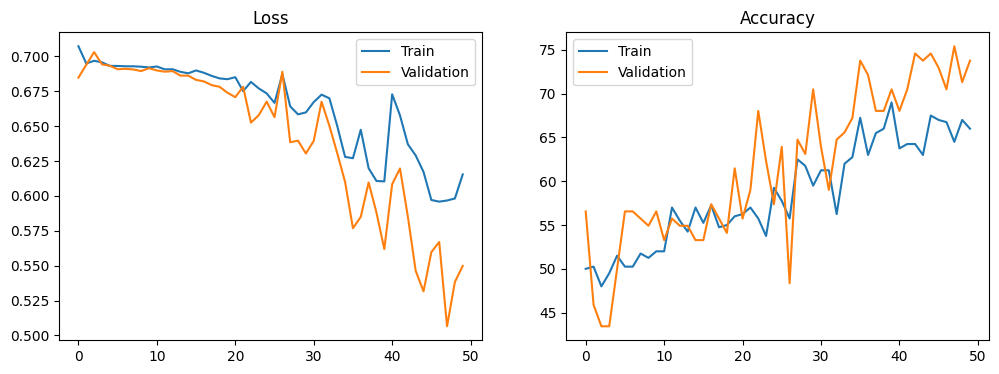

In [10]:
model_aug = CNN(num_classes=2).to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.01, momentum=0.9)

history_aug = train_model(model_aug, train_loader_aug, val_loader, criterion_aug, optimizer_aug, device, num_epochs=50)

plot_history(history_aug)

## Exercícios

### Exercício 1
Quais transformações podem ser adicionadas ainda ao processo de data augmentation deste problema? Entre na documentação em https://pytorch.org/vision/stable/transforms.html e escolha, defina os parâmetros e treine novamente o modelo com no mínimo 3 novas transformações.

In [14]:
# Transformacoes para data  auug
transform_aug_ex1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.3),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1.5)),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug_ex1 = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug_ex1 = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                            transform=transform_no_aug_ex1)
train_set_aug_ex1 = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=transform_aug_ex1)
val_set_ex1 = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                   transform=transform_no_aug_ex1)

train_loader_no_aug_ex1 = DataLoader(train_set_no_aug_ex1, batch_size=32,
                                     shuffle=True)
train_loader_aug_ex1 = DataLoader(train_set_aug_ex1, batch_size=32,
                                  shuffle=True)
val_loader_ex1 = DataLoader(val_set_ex1, batch_size=32,
                            shuffle=True)

100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 1, Train Loss: 0.694, Train Accuracy: 50.50%
Epoch 1, Val Loss: 0.692, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.694, Train Accuracy: 47.75%
Epoch 2, Val Loss: 0.695, Val Accuracy: 43.44%


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 3, Train Loss: 0.694, Train Accuracy: 49.00%
Epoch 3, Val Loss: 0.689, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 4, Train Loss: 0.693, Train Accuracy: 51.50%
Epoch 4, Val Loss: 0.690, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 5, Train Loss: 0.693, Train Accuracy: 51.75%
Epoch 5, Val Loss: 0.692, Val Accuracy: 49.18%


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 6, Train Loss: 0.693, Train Accuracy: 53.50%
Epoch 6, Val Loss: 0.687, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 7, Train Loss: 0.691, Train Accuracy: 54.50%
Epoch 7, Val Loss: 0.691, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


Epoch 8, Train Loss: 0.690, Train Accuracy: 57.50%
Epoch 8, Val Loss: 0.688, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 9, Train Loss: 0.690, Train Accuracy: 55.00%
Epoch 9, Val Loss: 0.681, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 10, Train Loss: 0.688, Train Accuracy: 57.25%
Epoch 10, Val Loss: 0.682, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch 11, Train Loss: 0.688, Train Accuracy: 54.25%
Epoch 11, Val Loss: 0.681, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 12, Train Loss: 0.685, Train Accuracy: 58.25%
Epoch 12, Val Loss: 0.674, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 13, Train Loss: 0.685, Train Accuracy: 55.50%
Epoch 13, Val Loss: 0.670, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


Epoch 14, Train Loss: 0.678, Train Accuracy: 61.75%
Epoch 14, Val Loss: 0.664, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 15, Train Loss: 0.678, Train Accuracy: 58.50%
Epoch 15, Val Loss: 0.651, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 16, Train Loss: 0.671, Train Accuracy: 60.50%
Epoch 16, Val Loss: 0.636, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Epoch 17, Train Loss: 0.659, Train Accuracy: 62.25%
Epoch 17, Val Loss: 0.610, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


Epoch 18, Train Loss: 0.665, Train Accuracy: 58.50%
Epoch 18, Val Loss: 0.601, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 19, Train Loss: 0.649, Train Accuracy: 63.50%
Epoch 19, Val Loss: 0.607, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 20, Train Loss: 0.655, Train Accuracy: 61.75%
Epoch 20, Val Loss: 0.592, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


Epoch 21, Train Loss: 0.661, Train Accuracy: 60.50%
Epoch 21, Val Loss: 0.613, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Epoch 22, Train Loss: 0.659, Train Accuracy: 62.25%
Epoch 22, Val Loss: 0.602, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 23, Train Loss: 0.638, Train Accuracy: 63.75%
Epoch 23, Val Loss: 0.588, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Epoch 24, Train Loss: 0.655, Train Accuracy: 60.75%
Epoch 24, Val Loss: 0.652, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 25, Train Loss: 0.676, Train Accuracy: 62.25%
Epoch 25, Val Loss: 0.582, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 26, Train Loss: 0.638, Train Accuracy: 65.75%
Epoch 26, Val Loss: 0.583, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 27, Train Loss: 0.652, Train Accuracy: 62.00%
Epoch 27, Val Loss: 0.568, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 28, Train Loss: 0.640, Train Accuracy: 65.00%
Epoch 28, Val Loss: 0.551, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 29, Train Loss: 0.626, Train Accuracy: 65.75%
Epoch 29, Val Loss: 0.573, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


Epoch 30, Train Loss: 0.622, Train Accuracy: 68.25%
Epoch 30, Val Loss: 0.565, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 31, Train Loss: 0.625, Train Accuracy: 66.00%
Epoch 31, Val Loss: 0.550, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 32, Train Loss: 0.635, Train Accuracy: 63.25%
Epoch 32, Val Loss: 0.566, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


Epoch 33, Train Loss: 0.615, Train Accuracy: 66.00%
Epoch 33, Val Loss: 0.549, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Epoch 34, Train Loss: 0.604, Train Accuracy: 67.75%
Epoch 34, Val Loss: 0.535, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 35, Train Loss: 0.630, Train Accuracy: 65.25%
Epoch 35, Val Loss: 0.547, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Epoch 36, Train Loss: 0.615, Train Accuracy: 66.75%
Epoch 36, Val Loss: 0.586, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


Epoch 37, Train Loss: 0.612, Train Accuracy: 67.00%
Epoch 37, Val Loss: 0.552, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 38, Train Loss: 0.598, Train Accuracy: 67.25%
Epoch 38, Val Loss: 0.530, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


Epoch 39, Train Loss: 0.608, Train Accuracy: 66.25%
Epoch 39, Val Loss: 0.517, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


Epoch 40, Train Loss: 0.600, Train Accuracy: 68.00%
Epoch 40, Val Loss: 0.530, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


Epoch 41, Train Loss: 0.635, Train Accuracy: 63.75%
Epoch 41, Val Loss: 0.597, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 42, Train Loss: 0.638, Train Accuracy: 65.00%
Epoch 42, Val Loss: 0.532, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


Epoch 43, Train Loss: 0.616, Train Accuracy: 64.25%
Epoch 43, Val Loss: 0.534, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Epoch 44, Train Loss: 0.594, Train Accuracy: 69.75%
Epoch 44, Val Loss: 0.538, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 45, Train Loss: 0.623, Train Accuracy: 66.25%
Epoch 45, Val Loss: 0.562, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 46, Train Loss: 0.593, Train Accuracy: 68.50%
Epoch 46, Val Loss: 0.541, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 47, Train Loss: 0.613, Train Accuracy: 68.00%
Epoch 47, Val Loss: 0.483, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 48, Train Loss: 0.624, Train Accuracy: 64.25%
Epoch 48, Val Loss: 0.526, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 49, Train Loss: 0.633, Train Accuracy: 66.25%
Epoch 49, Val Loss: 0.547, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 50, Train Loss: 0.580, Train Accuracy: 71.25%
Epoch 50, Val Loss: 0.487, Val Accuracy: 77.05%
Treinamento concluído


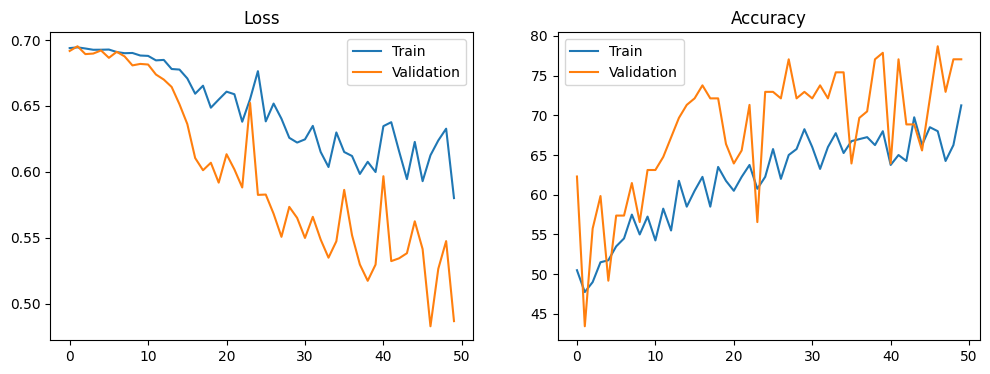

In [16]:
# treinamento do modelo
model_aug_ex1 = CNN(num_classes=2).to(device)

criterion_aug_ex1 = nn.CrossEntropyLoss()
optimizer_aug_ex1 = optim.SGD(model_aug_ex1.parameters(), lr=0.01, momentum=0.9)

history_aug_ex1 = train_model(model_aug_ex1, train_loader_aug_ex1, val_loader_ex1,
                          criterion_aug_ex1, optimizer_aug_ex1,
                          device, num_epochs=50)

plot_history(history_aug_ex1)